In [1]:
#Importing all require packages and libraries
import cython
import summit
from summit.benchmarks import ExperimentalEmulator
from summit.domain import *
from summit.utils.dataset import DataSet
from summit.strategies import SOBO, MultitoSingleObjective, LHS
import numpy as np
import pandas as pd
import pkg_resources
import pathlib
import os
import matplotlib.pyplot as plt

In [2]:
#Reading the input data (Boundaries.csv and Data.csv)
BASE_PATH = pathlib.Path("F:/Python Programs/DrewAWL")
DATA_PATH = BASE_PATH / "Data"
MODEL_PATH = BASE_PATH / "Models"
ITER_PATH = BASE_PATH / "IterData"
InitialBounds_name = "DrewBounds.csv"
WorkData_name = "DrewAWL_Exp.csv"
Project_name = "AWL_Optimization"

InitialBounds_df = pd.read_csv(DATA_PATH / InitialBounds_name)

In [3]:
InitialBounds_df

,Condition,Type,Categories,BoundaryMin,BoundaryMax,Description,Maximize
0,Res_Time,Continuous,NaN,30,90,Residence Time in total reactors,NaN
1,TempZ1,Continuous,NaN,10,30,Temperature of the first crystallizer,NaN
2,TempZ2,Continuous,NaN,0,10,Temperature of the second crystallizer,NaN
3,Main_Product,Objective,NaN,0,1,LCAP of Main Product,True
4,PSD,Objective,NaN,0,1,LCAP of Main Impurity,False


In [4]:
#Creating the domain utilizing the Boundaries.csv
domain = Domain()
Objective_df = pd.DataFrame()
Objective_df = DataSet.from_df(Objective_df)
InputCount = 0
OutputCount = 0

for idx, row in InitialBounds_df.iterrows():
    name = row[0]  
    description = row[5]  
    data_type = row['Type']
    
    if data_type == 'Categorical':
        levels = row[2].split(',')  
        
        domain += CategoricalVariable(
            name = name,
            description = description,
            levels = levels
        )
        InputCount += 1
        
    elif data_type == 'Continuous':
        bounds = [row[3], row[4]]
        
        domain += ContinuousVariable(
            name = name,
            description = description,
            bounds = bounds
        )
        InputCount += 1
        
    elif data_type == 'Objective':
        bounds = [row[3], row[4]]
        maximize = row[6]
        
        domain += ContinuousVariable(
            name = name,
            description = description,
            bounds = bounds,
            is_objective = True,
            maximize = maximize
        )
        OutputCount += 1

        Objective_df[(name, "DATA")] = ""

In [5]:
#Basic function just to report the iteration number
def ItCount(InitialExp, CompleteExp, Project):
    
    #Creates the counting system to identify which model and iteration is being looked all
    ItNum = CompleteExp - InitialExp
    ExpIt = ItNum + 1
    PrevModelNum = ItNum - 1

    #Creating the name plates for all the model and iteration names for referencing
    ModelName = f"{Project}_Model_It{ItNum}.json"
    PrevModelName = f"{Project}_Model_It{PrevModelNum}.json"
    ItName = f"{Project}_ExpIt{ExpIt}.csv"
    PrevItName = f"{Project}_ExpIt{ItNum}.csv"

    return ItNum, ModelName, PrevModelName, ItName, PrevItName

#Function to create initial Data.csv file and dataset
def create_initial_dataset(domain, WorkData_name, StartExp_num):

    categorical_method: str = "one-hot"
    
    StartStrat = LHS(domain = domain,
                     random_state = np.random.RandomState(808),
                     categorical_method = "one-hot")
    
    StartExp_Intermediate = pd.DataFrame(StartStrat.suggest_experiments(StartExp_Num))
    StartExp = pd.concat([StartExp_Intermediate, Objective_df], axis = 1)
    StartExp.to_csv(DATA_PATH / WorkData_name, index = True)
    print(f"The file '{WorkData_name}' does not exist in the directory. A new file has been created, please update it with results")
    
#Function to do Summit optimization
def perform_summit_optimization(WorkData_df, SuggestionAmount, expression, domain, Project_name, MODEL_PATH, ITER_PATH, StartExp_Num, Complete_num):
    
    ItNum, ModelName, PrevModelName, ItName, PrevItName = ItCount(StartExp_Num, Complete_num, Project_name)

    #Check Data.csv only has the starting experiments
    if ItNum == 0:

        #Setting up the Summit Optimization parameters
        transform = MultitoSingleObjective(
            domain = domain,
            expression = expression,
            maximize = True
        )
        strategy = SOBO(
            domain = domain,
            transform = transform
        )

        #Creates the first iteration suggestion and creates the first model
        NewIt = strategy.suggest_experiments(
            num_experiments = SuggestionAmount,
            prev_res = WorkData_df
        )
        IterExp_df = pd.concat([WorkData_df, NewIt], axis = 0)
        IterExp_df.reset_index(drop = True, inplace = True)
        #IterExp_df.to_csv(DATA_PATH / WorkData_name, index = True)
        NewIt.to_csv(ITER_PATH / ItName)
        strategy.save(MODEL_PATH / ModelName)
        print("Your first new experimental condition has been added to run. The model has been saved in the directory.")

    #If there has already been previous iterations 
    else: 

        PrevIt = WorkData_df.iloc[-1:].copy()
        PrevIt.to_csv(ITER_PATH / PrevItName)
        strategy = SOBO.load(MODEL_PATH / PrevModelName)
        NewIt = strategy.suggest_experiments(
            num_experiments = SuggestionAmount,
            prev_res = PrevIt
        )
        IterExp_df = pd.concat([WorkData_df, NewIt], axis = 0)
        IterExp_df.reset_index(drop = True, inplace = True)
        #IterExp_df.to_csv(DATA_PATH / WorkData_name, index = True)
        NewIt.to_csv(ITER_PATH / ItName)
        strategy.save(MODEL_PATH / ModelName)
        print("A new experimental condition has been added to run. The model has been saved in the directory.")
        
def main():
    
    #Setting up constant variables
    file_path = os.path.join(DATA_PATH, WorkData_name)
    SuggestionAmount = 1
    expression = "Main_Product-Main_Impurity"
    
    #Checking if the file does not exist
    if not os.path.exists(file_path):
        
        create_initial_dataset(domain, WorkData_name, StartExp_Num)
        
        return
    
    #Confirming the Data.csv and loading it in as a dataframe
    WorkData_df = DataSet.read_csv(DATA_PATH / WorkData_name) 
    print(f"The file '{WorkData_name}' exists in the directory.")
    
    #Counting the experiments done and the amount of total experiments suggested 
    Exp_num = WorkData_df.iloc[:, 0].count()
    Complete_num = WorkData_df.iloc[:, -1].count()
    
    #Checking if all the experiments are not done
    if Exp_num - Complete_num != 0:
        
        print("Complete experiments and update .csv file.")
        
        return
    
    #Beginning the summit optimization process
    perform_summit_optimization(WorkData_df, SuggestionAmount, expression, domain, Project_name, MODEL_PATH, ITER_PATH, StartExp_Num, Complete_num)

StartExp_Num = 10 #Find a better spot for this

#Calling the code
if __name__ == "__main__":
    main()

The file 'DrewAWL_Exp.csv' does not exist in the directory. A new file has been created, please update it with results


In [6]:
WorkData_df = DataSet.read_csv(DATA_PATH / WorkData_name) 

In [7]:
WorkData_df

,Res_Time,TempZ1,TempZ2,strategy,Main_Product,PSD
0,39.0,27.0,4.5,LHS,NaN,NaN
1,69.0,19.0,3.5,LHS,NaN,NaN
2,63.0,13.0,6.5,LHS,NaN,NaN
3,81.0,23.0,7.5,LHS,NaN,NaN
4,87.0,15.0,9.5,LHS,NaN,NaN
5,51.0,25.0,8.5,LHS,NaN,NaN
6,33.0,11.0,1.5,LHS,NaN,NaN
7,57.0,29.0,0.5,LHS,NaN,NaN
8,75.0,17.0,2.5,LHS,NaN,NaN
9,45.0,21.0,5.5,LHS,NaN,NaN


In [8]:
NewWorkColumnName = ('Achievement_Function','DATA')

WorkData_df[NewWorkColumnName] = WorkData_df.iloc[:, -2] - WorkData_df.iloc[:, -1]
sortedWorkData_df = WorkData_df.copy()
sortedWorkData_df.sort_values(by = NewWorkColumnName, ascending = False, inplace = True)

NewBoundsColumnName = 'Threshold'
Threshold_Fraction = 0.10
ThreshBounds_df = InitialBounds_df.copy()
ThreshBounds_df[NewBoundsColumnName] = (InitialBounds_df.iloc[:, 4] - InitialBounds_df.iloc[:, 3])*Threshold_Fraction
InputThreshBounds_df = ThreshBounds_df[:-OutputCount]

Threshold_Fraction_AF = 0.025
AF_Bounds = [-1,1] #Change this to automatic later on
Threshold_AF = (AF_Bounds[1] - AF_Bounds[0])*Threshold_Fraction_AF

In [9]:
#All check functions

#Checks the average difference of the top 3 achievement functions
def checkAverage(df):
    AverTop3 = df.iloc[:3, -1].mean()
    AverDiff = df.iloc[:3, -1].sub(AverTop3).abs().mean()
    return AverDiff


def BoundChecks(Data_df, Bound_df):
    C2Max = []
    C2Min = []
    ExpCheck = Data_df.iloc[0, 0:6].to_numpy()
    
    for idx, row in Bound_df.iterrows():
        Col_Name = row['Condition']
        MinBou = row['BoundaryMin']
        MaxBou = row['BoundaryMax']
        Thresh = row['Threshold']
        Val = ExpCheck[idx]
        
        if np.isfinite(Val):
            if (Val - MinBou) < Thresh:
                C2Min.append(Col_Name)
            elif (MaxBou - Val) < Thresh:
                C2Max.append(Col_Name)
                
    BC_Status = int(bool(C2Max or C2Min)) 

    return C2Max, C2Min, BC_Status

def checkMaxPossibility(sortedWorkData_df, Threshold_AF):
    
    if abs(sortedWorkData_df.iloc[0, -1] - AF_Bounds[1]) < Threshold_AF:
        print('Near Max possibility')
        
        return True
    
    return False

def checkOptimizedToGoal(sortedWorkData_df, Goal):
    
    if sortedWorkData_df.iloc[0, -1] > Goal:
        print('Optimized to goal within given boundaries')
        
        return True
    
    return False

def resumeOptimization(sortedWorkData_df, InputThreshBounds_df, InitialBounds_df, ExpansionCoef, Threshold_Fraction):
    
    C2Max, C2Min, BC_Status = BoundChecks(sortedWorkData_df, InputThreshBounds_df)
    
    if not (C2Max or C2Min):
        
        print('Resume Optimization Process')
        
        return True
    
    for condition in C2Max:
        
        Boundrow = InitialBounds_df.loc[InitialBounds_df.iloc[:, 0] == condition]
        Boundrow.iloc[:, 4] += ExpansionCoef * ((Boundrow.iloc[:, 4] - Boundrow.iloc[:, 3]) * Threshold_Fraction)
        InitialBounds_df.loc[InitialBounds_df.iloc[:, 0] == condition] = Boundrow
        
    for condition in C2Min:
        
        Boundrow = InitialBounds_df.loc[InitialBounds_df.iloc[:, 0] == condition]
        Boundrow.iloc[:, 3] -= ExpansionCoef * ((Boundrow.iloc[:, 4] - Boundrow.iloc[:, 3]) * Threshold_Fraction)
        InitialBounds_df.loc[InitialBounds_df.iloc[:, 0] == condition] = Boundrow
        
    return False

def CheckStep(sortedWorkData_df, InputThreshBounds_df, InitialBounds_df, Goal, AF_Bounds, ExpansionCoef, Threshold_Fraction):
    
    if checkMaxPossibility(sortedWorkData_df, Threshold_AF):
        
        return 1
    
    elif checkAverage(sortedWorkData_df) < (Threshold_AF / 2):
        
        if checkOptimizedToGoal(sortedWorkData_df, Goal):
            
            return 2
        
        elif not resumeOptimization(sortedWorkData_df, InputThreshBounds_df, InitialBounds_df, ExpansionCoef, Threshold_Fraction):
            
            return 4
        
        else:
            
            return 3
        
    else:
        
        print('Continue with Optimization Process')
        
        return 4
    
Goal = 0.8
ExpansionCoef = 2
Check = CheckStep(sortedWorkData_df, InputThreshBounds_df, InitialBounds_df, Goal, AF_Bounds, ExpansionCoef, Threshold_Fraction)
print('This is check step', Check)

Continue with Optimization Process
This is check step 4


In [10]:
InitialBounds_df

,Condition,Type,Categories,BoundaryMin,BoundaryMax,Description,Maximize
0,Res_Time,Continuous,NaN,30,90,Residence Time in total reactors,NaN
1,TempZ1,Continuous,NaN,10,30,Temperature of the first crystallizer,NaN
2,TempZ2,Continuous,NaN,0,10,Temperature of the second crystallizer,NaN
3,Main_Product,Objective,NaN,0,1,LCAP of Main Product,True
4,PSD,Objective,NaN,0,1,LCAP of Main Impurity,False


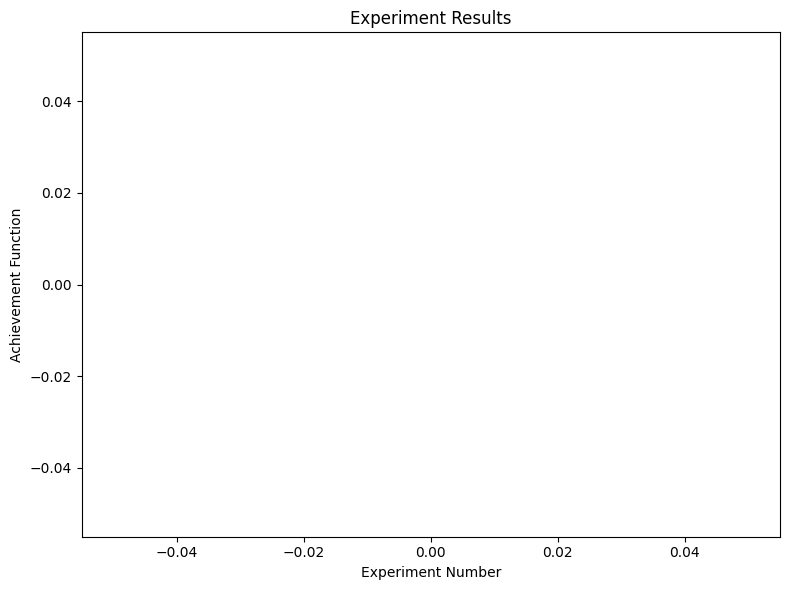

In [11]:
#Temp
StartExp_Num = 10

ExperimentNumber = WorkData_df.index + 1  
AchievementFunction = WorkData_df.iloc[:, -1]

MaxAF_Start = AchievementFunction[:StartExp_Num].max()
MaxAF_Rest = AchievementFunction[StartExp_Num:].max()

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(ExperimentNumber[:StartExp_Num], AchievementFunction[:StartExp_Num], marker='o', linestyle='-',
         color='grey', markersize=5, linewidth=1, label='Best Achievement')
plt.plot(ExperimentNumber[StartExp_Num:], AchievementFunction[StartExp_Num:], marker='o', linestyle='-',
         color='navy', markersize=5, linewidth=1, label='Best Achievement')
plt.xlabel('Experiment Number')
plt.ylabel('Achievement Function')
plt.title('Experiment Results')
plt.tight_layout()  
plt.show()

In [12]:
#temp
Exp_num = 14

emul = ExperimentalEmulator(
    model_name = Project_name,
    domain = domain,
    dataset = WorkData_df
)

emul.train(
    max_epochs = 1000,
    cv_fold = Exp_num,
    random_state = 410,
    test_size = 0.1,
    verbose = 0
)

fig, ax = emul.parity_plot(include_test=True)

#Prediction_raw = emul.run_experiments(NewIt)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\slend\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\slend\AppData\Roaming\Python\Python39\site-packages\summit\benchmarks\experimental_emulator.py", line 1015, in fit
    y = check_array(
  File "C:\Users\slend\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py", line 959, in check_array
    _assert_all_finite(
  File "C:\Users\slend\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "C:\Users\slend\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input contains NaN.
